## SARIMA Models (Practice)
For this assignment, you will be predicting energy consumption for the next 24 months. You will ultimately be comparing a seasonal and nonseasonal model.

You can access the data here. (Original Source)
* We will look at the "Consumption" column for our time series.
* Convert the Date column to datetime and make it the index.
* Resample the data to a monthly frequency calculated with the mean.
* Check for and address missing values.
* Plot the time series.

ARIMA
* Use ndiffs to determine if nonseasonal differencing is required
* Plot ACF and PACF to estimate initial orders
* Train test split the data using a test_size equal to the length of the final forecast (24 months) and visualize the result.
* Run an ARIMA model with the orders determined based on your EDA.
* Obtain the model summary, plot diagnostics, plot the forecasts with confidence intervals, and obtain regression metrics for the ARIMA model.

SARIMA
* Use nsdiffs to determine if seasonal differencing is required
* Apply seasonal decomposition to the data
* Plot the seasonal component to determine m.
* Determine the size and relative size of m.
* Examine the seasonal lags of the ACF/PACF to determine seasonal orders
* Run a SARIMA model with the orders determined based on your EDA.
* Obtain the model summary, plot diagnostics, plot the forecasts with confidence intervals, and obtain regression metrics for the ARIMA model.
* Notice how adding a seasonal component improves this model

Submit below.

### Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

### Custom Functions

In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

### Load Data

In [7]:
df = pd.read_csv('Data/opsd_germany_daily.csv')
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [8]:
# Convert Date column to datetime dtype
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4383 non-null   datetime64[ns]
 1   Consumption  4383 non-null   float64       
 2   Wind         2920 non-null   float64       
 3   Solar        2188 non-null   float64       
 4   Wind+Solar   2187 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 171.3 KB


In [9]:
# Change Date to index
df = df.set_index('Date')
df.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

In [11]:
# Define ts with Consumption column and resample to Monthly using mean
ts = df['Consumption'].resample('M').mean()
ts

Date
2006-01-31    1461.442065
2006-02-28    1467.106893
2006-03-31    1418.649161
2006-04-30    1275.058900
2006-05-31    1253.488484
                 ...     
2017-08-31    1291.283022
2017-09-30    1335.952031
2017-10-31    1366.297385
2017-11-30    1477.990818
2017-12-31    1435.842075
Freq: M, Name: Consumption, Length: 144, dtype: float64

In [12]:
# Check for nulls
ts.isna().sum()

0

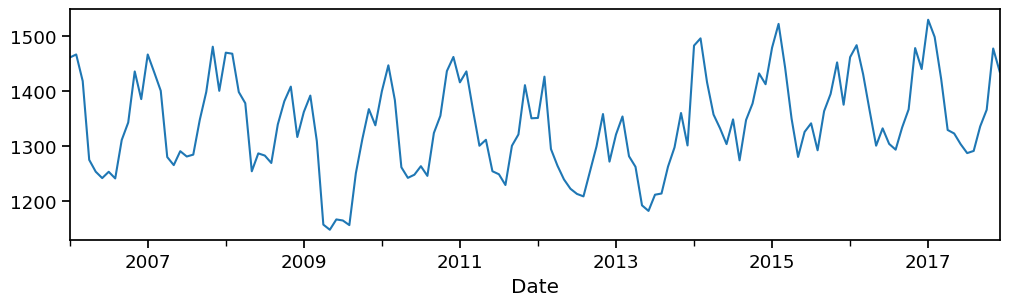

In [13]:
# Plot the time series
ts.plot();

C:\Users\bandi\AppData\Local\Temp\ipykernel_36248\1446163818.py:6: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


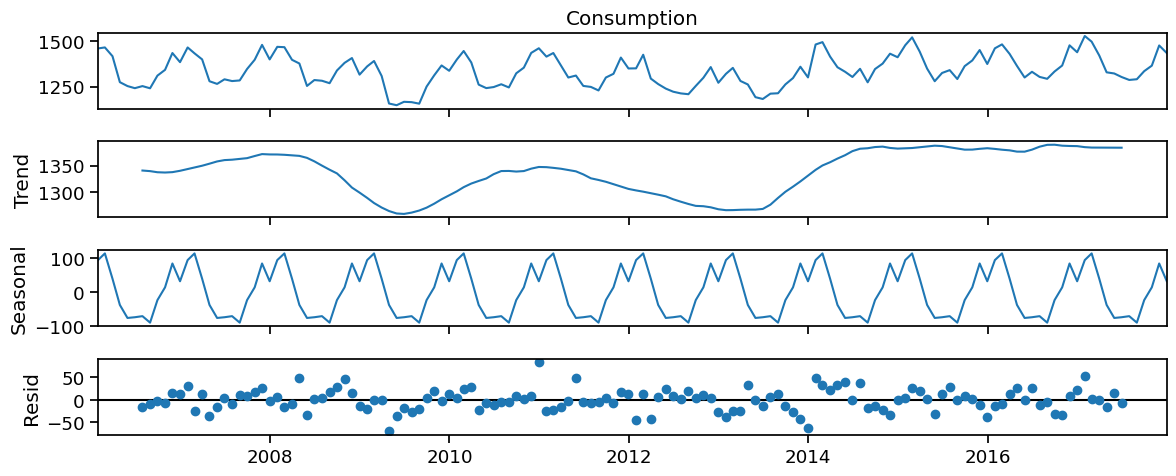

In [14]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [15]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 202.8199389305879 which is ~52.99% of the variation in time series.


In [17]:
# check for nonseasonal differencing
d = ndiffs(ts)
print(f'd = {d}')

d = 0


In [21]:
# check for seasonal differencing
D = nsdiffs(ts, m = 12)
print(f'D = {D}')

D = 0


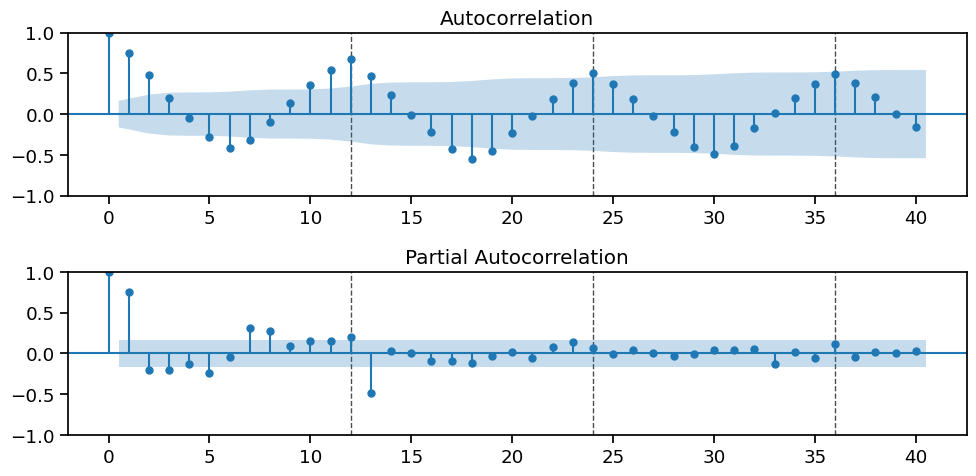

In [22]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts, annotate_seas=True, m = 12);

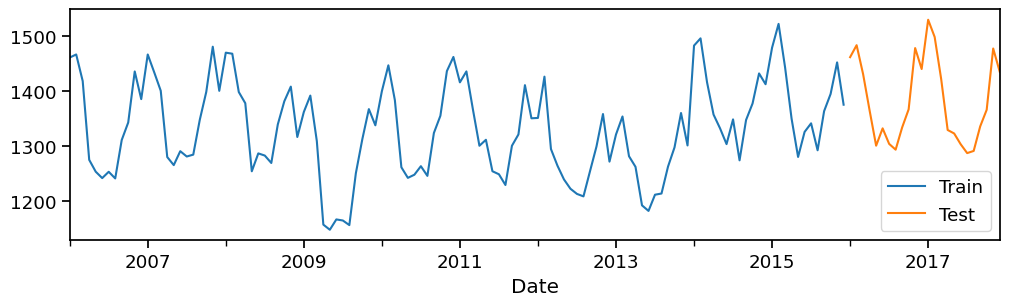

In [23]:
# tts using test size equal to 24 lags
test_lags = 24
train, test = train_test_split(ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

### Run an ARIMA model

In [24]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

# Define and fit the model
arima = tsa.ARIMA(train, order=(p,d,q)).fit()

# Obtain summary
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  120
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -653.886
Date:                Tue, 02 Apr 2024   AIC                           1313.773
Time:                        20:47:13   BIC                           1322.135
Sample:                    01-31-2006   HQIC                          1317.169
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1334.9675     20.412     65.401      0.000    1294.961    1374.974
ar.L1          0.7558      0.074     10.171      0.000       0.610       0.901
sigma2      3143.5980    412.704      7.617      0.000    2334.713    3952.484
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.12   Prob(JB):                         0.99
Heteroskedasticity (H):               0.87   Skew:                             0.02
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

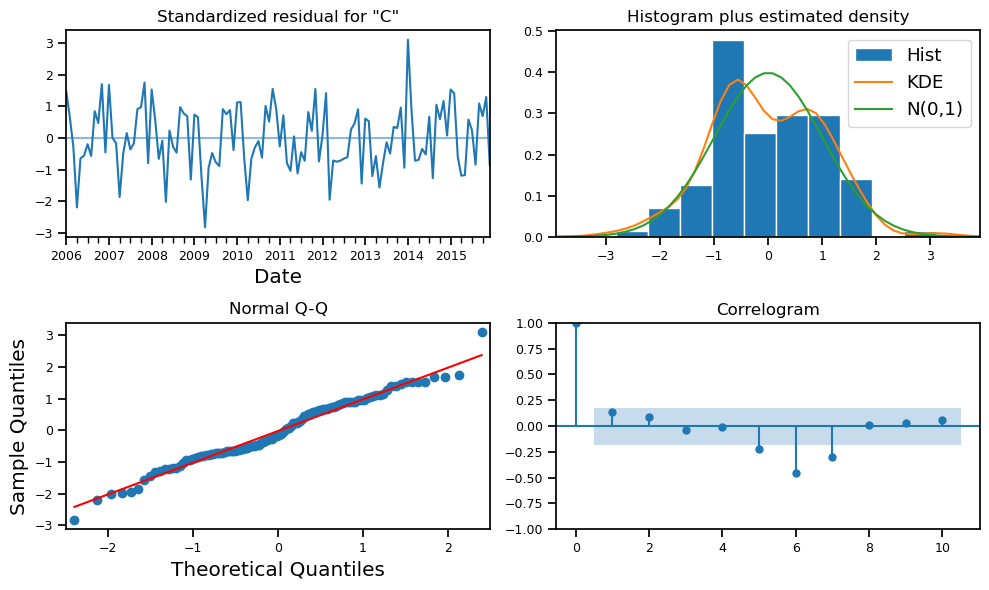

In [37]:
# Obtain diagnostic plots
fig = arima.plot_diagnostics()
fig.set_size_inches(10, 6)

# Adjust the text and title size for each subplot
for ax in fig.axes:
    ax.set_title(ax.get_title(), fontsize=12)  # Reduce the title font size
    ax.tick_params(axis='x', labelsize=9)  # Reduce the x-axis label size
    ax.tick_params(axis='y', labelsize=9)  # Reduce the y-axis label size

fig.tight_layout()
plt.show()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 66.492
- MSE = 7,412.715
- RMSE = 86.097
- R^2 = -0.279
- MAPE = 4.63%


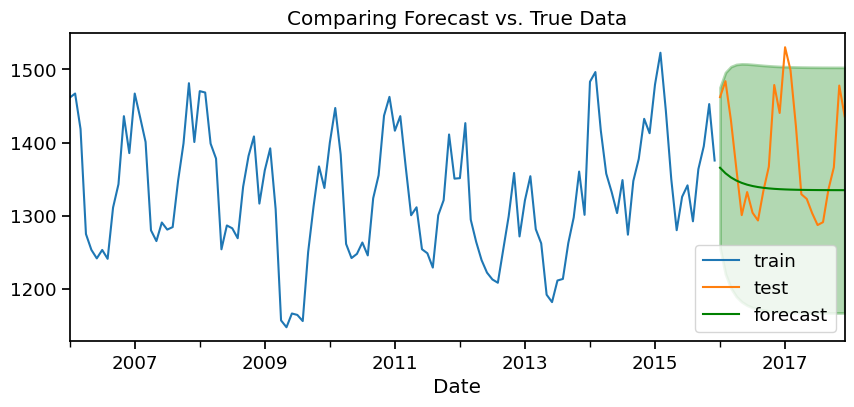

In [38]:
# Obtain summary of forecast as dataframe
forecast_df = arima.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df);

# Obtain regression metrics
regression_metrics_ts(test, forecast_df['mean'])

* Visualization of the forecast against the actual test data indicates that the model fails to capture the seasonal fluctuations which are characteristic of the energy consumption data.

### Fitting a SARIMA Model

In [39]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

# Define and fit the model
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                  120
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -602.870
Date:                            Tue, 02 Apr 2024   AIC                           1215.739
Time:                                    21:36:25   BIC                           1229.677
Sample:                                01-31-2006   HQIC                          1221.399
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.7459     57.851     23.003      0.000    1217.361    1444.131
ar.L1          0.7880      0.058     13.540      0.000       0.674       0.902
ar.S.L12       0.9954      0.011     91.930      0.000       0.974       1.017
ma.S.L12      -0.8622      0.157     -5.478      0.000      -1.171      -0.554
sigma2      1088.4188    201.853      5.392      0.000     692.794    1484.044
===================================================================================
Ljung-Box (L1) (Q):                   4.23   Jarque-Bera (JB):                23.65
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.91   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

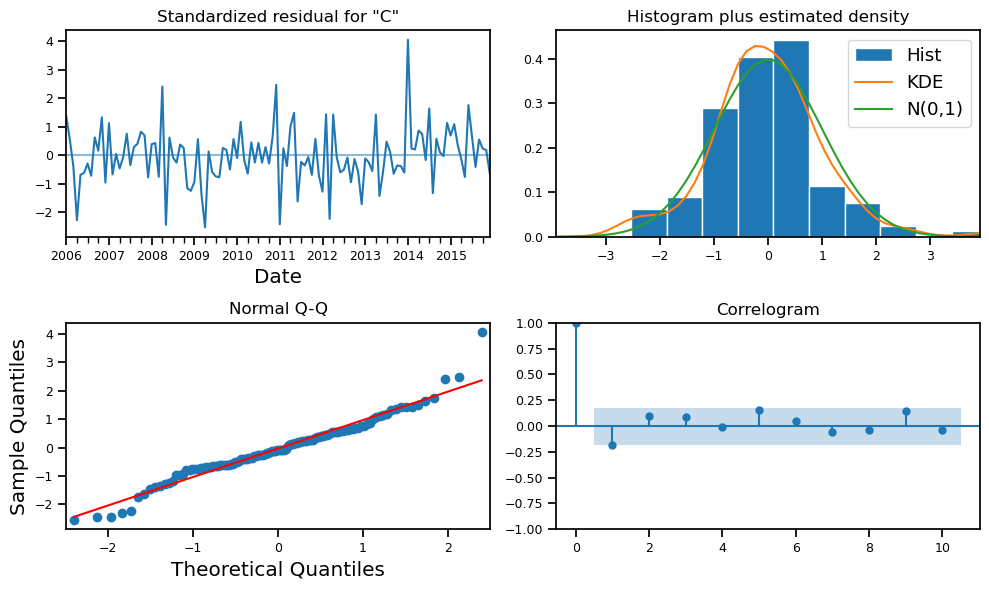

In [41]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10, 6)

# Adjust the text and title size for each subplot
for ax in fig.axes:
    ax.set_title(ax.get_title(), fontsize=12)  # Reduce the title font size
    ax.tick_params(axis='x', labelsize=9)  # Reduce the x-axis label size
    ax.tick_params(axis='y', labelsize=9)  # Reduce the y-axis label size

fig.tight_layout()
plt.show()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 46.242
- MSE = 2,688.650
- RMSE = 51.852
- R^2 = 0.536
- MAPE = 3.30%


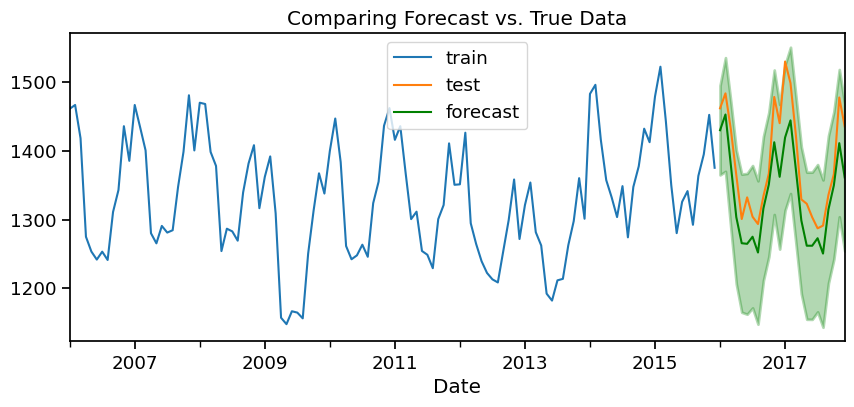

In [42]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df);

# Obtain regression metrics
regression_metrics_ts(test, forecast_df['mean'])

* The seasonal model follows the general seasonal cycles. Visually, the forecast closely overlaps the test data. 
* The seasonal model also has lower AIC score and preferred values for regression metrics.